In [309]:
# Import the necessary libraries
import random as rd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler


# seed for reproducibility
rd.seed(42)

In [310]:
#Import the Dataset
df = pd.read_csv(r"C:\Users\jwh28\Downloads\Processed_Data_Linear_Regression.csv")

In [311]:
#Standardize Data

X = df.drop(columns=['Addiction Level'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
df_scaled = pd.concat([df['Addiction Level'], X_scaled], axis=1)

In [312]:
#Split data into training and testing sets

train_full, test_full = train_test_split(
    df_scaled, test_size=0.2, random_state=100
)

X_train_full = train_full.drop(columns=['Addiction Level'])
y_train_full = train_full['Addiction Level']
X_test_full  = test_full.drop(columns=['Addiction Level'])
y_test_full  = test_full['Addiction Level']

In [313]:
#Initialize Ridge and Lasso models

lasso_lambdas = np.arange(0.01, 1.5, 0.01)
ridge_lambdas = np.arange(1, 1001, 9)

lasso = {"models": [], "coeffs": [],}
for l in lasso_lambdas:
    lasso_model = Lasso(alpha=l)
    lasso_model.fit(X_train_full, y_train_full)
    lasso["models"].append(lasso_model)
    lasso["coeffs"].append(lasso_model.coef_)

ridge = {"models": [], "coeffs": []}
for l in ridge_lambdas:
    ridge_model = Ridge(alpha=l)
    ridge_model.fit(X_train_full, y_train_full)
    ridge["models"].append(ridge_model)
    ridge["coeffs"].append(ridge_model.coef_)


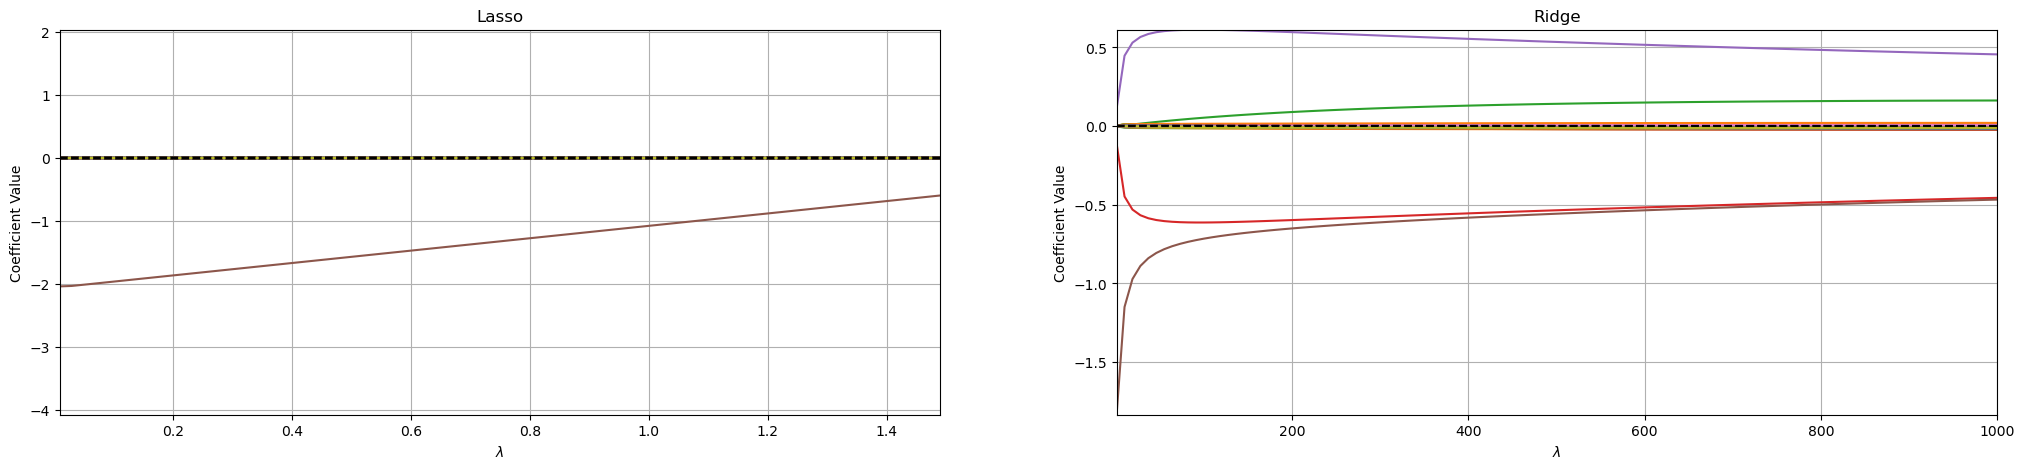

In [314]:
#Create Coefficient Plots
plt.figure(figsize=(25, 5))

num_features = len(lasso["coeffs"][0])
for i in range(num_features):
    feature_vals = [coef[i] for coef in lasso["coeffs"]]
    plt.subplot(1, 2, 1)
    plt.xlabel(r"$\lambda$")
    plt.plot(lasso_lambdas, feature_vals, label=fr"$\hat{{\beta}}_{{{i+1}}}$")
    plt.axhline(y=0, color='black', linestyle='--')

plt.grid()
plt.xlabel(r"$\lambda$")
plt.ylabel('Coefficient Value')
plt.title('Lasso')
plt.margins(0,1)

num_features = len(ridge["coeffs"][0])
for i in range(num_features):
    feature_vals = [coef[i] for coef in ridge["coeffs"]]
    plt.subplot(1, 2, 2)
    plt.plot(ridge_lambdas, feature_vals, label=fr"$\hat{{\beta}}_{{{i+1}}}$")
    plt.axhline(y=0, color='black', linestyle='--')

plt.grid()
plt.xlabel(r"$\lambda$")
plt.ylabel('Coefficient Value')
plt.title('Ridge')
plt.margins(0)

plt.show()

In [315]:
#Use K-Fold Cross Validation (K=5) to determine optimal Lambda Values
lasso_best_model_cv = LassoCV(alphas=lasso_lambdas, cv=5, max_iter=100000)
lasso_best_model_cv.fit(X_train_full, y_train_full.values.ravel())
lasso_best_lambda = lasso_best_model_cv.alpha_
print(f"Best lambda for Lasso: {lasso_best_lambda}")

ridge_best_model_cv = RidgeCV(alphas=ridge_lambdas, cv=5)
ridge_best_model_cv.fit(X_train_full, y_train_full.values.ravel()) 
ridge_best_lambda = ridge_best_model_cv.alpha_
print(f"Best lambda for Ridge: {ridge_best_lambda}")

Best lambda for Lasso: 0.01
Best lambda for Ridge: 1


In [316]:
#Fit the best Lasso and Ridge Models and Calculate MSE on the test set
lasso_best_model = Lasso(alpha=lasso_best_lambda)
lasso_best_model.fit(X_train_full, y_train_full)
lasso_y_pred = lasso_best_model.predict(X_test_full)
lasso_mse = mean_squared_error(y_test_full, lasso_y_pred)
print(f"Lasso MSE: {lasso_mse}")
print(f"Lasso - # of Nonzero Coefficients: {np.count_nonzero(lasso_best_model.coef_)}")

ridge_best_model = Ridge(alpha=ridge_best_lambda)
ridge_best_model.fit(X_train_full, y_train_full)
ridge_y_pred = ridge_best_model.predict(X_test_full)
ridge_mse = mean_squared_error(y_test_full, ridge_y_pred)
print(f"Ridge MSE: {ridge_mse}")
print(f"Ridge - # of Nonzero Coefficients: {np.count_nonzero(ridge_best_model.coef_)}")

Lasso MSE: 8.937705852176097e-05
Lasso - # of Nonzero Coefficients: 2
Ridge MSE: 0.0004736252449256337
Ridge - # of Nonzero Coefficients: 59


In [ ]:
coef_series = pd.Series(lasso_best_model.coef_, index=X_train_full.columns)

nonzero_coefs = coef_series[coef_series != 0]

print("Lasso selected features and their coefficients:")
print(nonzero_coefs)

Lasso selected features and their coefficients:
ProductivityLoss   -0.013142
Self Control       -2.034582
dtype: float64
